In [86]:
import numpy as np
import random as rd
import math as mp
import scipy.integrate as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

In [106]:
steps=5
birds=50
B1=0.5
H=0.1
ndim=3


#Variabili utili nel programma
C=0.003
D3=0.0015
E3=0.0003
D0=1
E0=1
P1=0.1
D1=5
E1=2.5
S1=1.047
S2=1.57

alpha=14.4
beta=0.1

init_vel_max = 18
init_vel_min = 10
init_radius = 50

x_upper_bound = birds * ndim
v_lower_bound = x_upper_bound
v_upper_bound = 2 * birds * ndim

time_values = np.zeros((steps))
for i in range (steps):
    time_values[i] = i

init_phase_space = np.zeros((birds * 2 * ndim))

In [91]:
def get_pos(bird_set, i, k):
    return bird_set[i*ndim + k]

def get_vel(bird_set, i, k):
    return bird_set[v_lower_bound + i*ndim + k]

In [92]:
def pos_diff_norm(bird_set, i, j):
    somma=0
    for k in range(ndim):
        somma += (get_pos(bird_set, i, k) - get_pos(bird_set, j, k))**2
    somma = mp.sqrt(somma)
    return somma

def vel_diff_norm(bird_set, i, j):
    somma=0
    for k in range(ndim):
        somma += (get_vel(bird_set, i, k) - get_vel(bird_set, j, k))**2
    somma = mp.sqrt(somma)
    return somma

In [93]:
def Aij(bird_set, i, j):
    return H / (pow(1 + pow(vel_diff_norm(bird_set, i, j), 2), beta))

In [94]:
def A(bird_set, i, j, k):
    v_jk = get_vel(bird_set, j, k)
    v_ik = get_vel(bird_set, i, k)
    
    return Aij(bird_set, i, j) * (v_jk - v_ik)

In [95]:
def rho(bird_set, i):
    somma = 0
    for j in range (birds):
        somma += 1/(1 + pos_diff_norm(bird_set, i, j) ** 2)
    return somma / birds

In [96]:
def levi_civita(i, j, k):
    if ((i == 1 and j == 2 and k == 3) or
        (i == 2 and j == 3 and k == 1) or
        (i == 3 and j == 1 and k == 2)):
        return 1
    elif ((i == 3 and j == 2 and i == 1) or
         (i == 1 and j == 3 and k == 2) or
         (i == 2 and j == 1 and k == 3)):
        return -1
    else:
        return 0

In [97]:
def cross_product(bird_set, i, k):
    somma = 0
    down = [0, 0, -1]

    for i_k in range(ndim):
        for down_k in range(ndim):
            somma += levi_civita(k, i_k, down_k) * get_vel(bird_set, i, i_k) * down[down_k]
    return somma

In [98]:
def B(bird_set, i, k):
    return C * cutoff(rho(bird_set, i),D3, E3) * cross_product(bird_set, i ,k)

In [ ]:
def R(bird_set, i, j, k):
    x_ik = get_pos(bird_set, i, k)
    x_jk = get_pos(bird_set, j, k)
    
    norm = diff_pos_norm(bird_set, i, j)
    
    cut = cutoff(norm, 0, )

In [99]:
def friction(bird_set, i, k):
    v_ik = get_vel(bird_set, i, k)
    somma = 0
    for l in range (ndim):
        somma+= get_vel(bird_set,i, l)**2
    v_norm = mp.sqrt(somma)
    
    return (alpha - beta * v_norm **2)* v_ik

In [100]:
def rhs_equation(t, phase_space):
    vett = np.zeros(birds * 2 * ndim)    
    
    #equazioni differenziali delle posizioni
    for i in range (birds):
        x_i = i*ndim
        for k in range(ndim):
            vett[x_i + k] = get_vel(phase_space, i, k)
    
    #equazioni differenziali delle velocità
    for i in range (birds):
        v_i = v_lower_bound + ndim * i
        
        somma = np.zeros((ndim))
        #somma per ogni componente di i
        
        for k in range (ndim):
            for j in range (birds):

                somma[k] += A(phase_space, i, j, k)
                
            somma[k] += B(phase_space, i, k) + friction(phase_space, i, k)
            vett[v_i + k] = somma[k]
    return vett

In [101]:
#Funzione cutoff per S0 e S1
def cutoff(x,d,e):
    if x <= d:
        return 1
    elif x < (d + e):
        return 0.5+0.5*np.tanh((1/(x-d))+(1/(x-(d+e))))
    else:
        return 0

In [102]:
#Calcolo w per la velocità come da articolo
def w(x,y,v):
    w1=Y1/pow(1+pow(np.linalg.norm(x-y),2),B1)
    w2=cutoff(np.linalg.norm(v),D1,E1)
    w3=(1-w2)
    w4=(np.dot((y-x),v))/((np.linalg.norm(y-x)*np.linalg.norm(v))) 
    w5=(1-cutoff(w4,np.cos(S2),np.cos(S1) - np.cos(S2))) #correzione messo coseno al posto dell'angolo
    return w1*(w2+w3*w5)

In [103]:
rd.seed()

#inizializzo le posizioni
for i in range (birds):
    x_i = ndim * i
    theta_x = rd.random() * mp.pi
    phi_x = rd.random() * 2 * mp.pi
    r = rd.random() * init_radius
    
    init_phase_space[x_i + 0]= r * mp.cos(phi_x) * mp.sin(theta_x)
    init_phase_space[x_i + 1]= r * mp.sin(phi_x) * mp.sin(theta_x)
    init_phase_space[x_i + 2]= r * mp.cos(theta_x)

#inizializzo le velocità
for i in range (birds):
    v_i = v_lower_bound + ndim * i
    theta_v = rd.random() * mp.pi
    phi_v = rd.random() * 2 * mp.pi
    v = rd.random() * (init_vel_max - init_vel_min) + init_vel_min
    
    init_phase_space[v_i + 0]= v * mp.cos(phi_v) * mp.sin(theta_v)
    init_phase_space[v_i + 1]= v * mp.sin(phi_v) * mp.sin(theta_v)
    init_phase_space[v_i + 2]= v * mp.cos(theta_v)

#print (init_phase_space.reshape(2, birds, ndim))

In [104]:
solution = sp.solve_ivp(fun=rhs_equation,y0 = init_phase_space, t_span=(0,steps))
print("done")

done


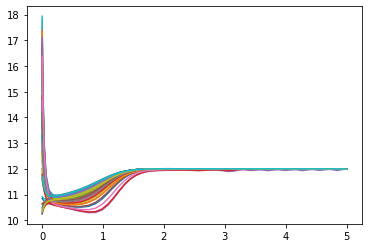

In [105]:
pos = solution.y[ : x_upper_bound]
vel = solution.y[v_lower_bound : ]
times = solution.t

#Converto in array 3D
vel = vel.reshape((birds, ndim, len(times)))
pos = pos.reshape((birds, ndim, len(times)))

vel = np.round(vel, 5)
pos = np.round(pos, 5)
times = np.round(times, 5)

file = open(f" ridefinito birds={birds} times={times.size} b={beta}.txt", "w+")
file.write("Num.\tVelx\tVely\tVelz\tPosx\tPosy\tPosz\tTimes\tStep\n")

ucc = 0
t = 0
for i in range(times.size * birds):
    file.write(str(ucc) + "\t" + str(vel[ucc][0][t]) + "\t" + str(vel[ucc][1][t]) + "\t" + str(vel[ucc][2][t]) + 
               "\t" + str(pos[ucc][0][t]) + "\t" + str(pos[ucc][1][t]) + "\t" + str(pos[ucc][2][t]) + 
               "\t" + str(times[t]) + "\t" + str(t) + "\n")
    ucc += 1
    if ucc == birds:
        ucc = 0
        t += 1     

norm_vel = np.zeros((birds, len(times)))
for i in range(birds):
    for t in range(len(times)):
        norm_vel[i, t] = np.linalg.norm(vel[i, :, t])
   
for i in range(birds):
    plt.plot(times, norm_vel[i,:])

file.close()